$\large{\textbf{Packages}}$

In [ ]:
# simple change again
from __future__ import division, print_function
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import pickle
import pandas as pd
import seaborn as sns
import time

$\large{\textbf{Data}}$

In [5]:
###############################################
#experimental data; crizotinib and lorlatinib #
###############################################

data = pd.read_excel(open('GradualColoniesForJake.xlsx','rb'), sheetname='Sheet1',index_col=False)
criz_data=np.array([data[name][1:] for name in ["Crizotinib","Unnamed: 1","Unnamed: 2","Unnamed: 3","Unnamed: 4"]])
lorl_data=np.array([data[name][1:] for name in ["Lorlatinib","Unnamed: 7","Unnamed: 8","Unnamed: 9","Unnamed: 10"]])

criz_ref_data = [[round(a) for a in data[np.where(data>0)]/200] for data in criz_data]
lorl_ref_data = [[round(a) for a in data[np.where(data>0)]/200] for data in lorl_data]

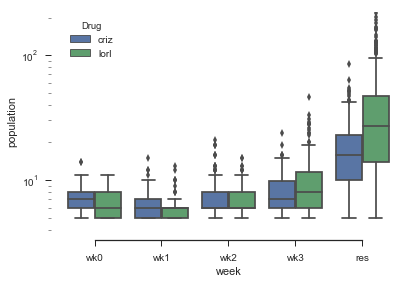

In [57]:
#########################################
# data visualization; 2-legend barchart #
#########################################

def swarm_xyz(dataZ, ticksX, ticksY, labels=["x","y","z"]
             , zrange=False, logZ=True
             , save=False, filename="save"):

    i, j = len(dataZ), len(dataZ[0])
    if len(ticksX)!=i or len(ticksY)!=j:
        print("data dimention is inconsistent")

    else:
        df = pd.DataFrame()
        
        x_list, y_list, z_list = [], [], []
        for ii in range(i):
            for jj in range(j):
                x_list.extend([ticksX[ii]]*len(dataZ[ii][jj]))
                y_list.extend([ticksY[jj]]*len(dataZ[ii][jj]))
                z_list.extend(dataZ[ii][jj])
        
        df[labels[0]] = x_list
        df[labels[1]] = y_list
        df[labels[2]] = z_list
        
        sns.set(style="ticks")
        sns.boxplot(x=labels[1], y=labels[2], hue=labels[0], data=df, dodge=True
                     )
        sns.despine(offset=10, trim=True)
        if logZ:
            plt.yscale('log')
        if zrange:
            plt.ylim(zrange[0], zrange[1])
        if save:
            plt.savefig(save+'.png' ,  bbox_inches='tight' , dpi=400)
        plt.show()
        
swarm_xyz([criz_ref_data, lorl_ref_data], ["criz","lorl"], ["wk0","wk1","wk2","wk3","res"], 
          labels=["Drug","week","population"], zrange=[4, 220], logZ=True)

$\large{\textbf{Functions}}$

In [5]:
####################################################################################
# Cellular Automaton model (CA); updating all the existing cells to next time step #
####################################################################################

def div(grid # n-by-n array filled with 0 (empty space) and 1 (taken by a cell)
        , div_rate # n-by-n array indicating division rates for existing cells and 0 for empty spots
        , step # n-by-n array indicating mutation status (an integer in [0,n_step]) for existing cells and 0 for empty spots
        , mu_rate # mutation rates
        , div_range=[0.1, 0.9] # range of division rates [d0,d1]
        , n_step=1 # number of steps required to reach from d0 to d1
       ):

    cell_list = np.nonzero( grid==1 ) # positions of existing cells on "grid"
    
    div_step = (div_range[1]-div_range[0])/n_step # increase in division rate per mutation
    N = len( cell_list[0] ) # number of existing cells
    indices = np.arange( N ) # indices of the N cells
    rand_indices = np.random.permutation( indices ) # random suffling of the indices 

    for cnum in rand_indices:
        row = cell_list[0][cnum]
        col = cell_list[1][cnum]

        rand = np.random.rand()
        
        if rand < div_rate[row,col]: # if 'yes', it can divide.
            search_grid = deepcopy(grid)           
            search_grid[row, col] = 2

            empty = np.nonzero( search_grid[ max(row-1,0) : min(row+2,len(grid)) , max(col-1,0) : min(col+2,len(grid)) ]==0 )
            org_ind = np.nonzero( search_grid[ max(row-1,0) : min(row+2,len(grid)) , max(col-1,0) : min(col+2,len(grid)) ]==2 )

            empty2 = np.nonzero( search_grid[ max(row-2,0) : min(row+3,len(grid)) , max(col-2,0) : min(col+3,len(grid)) ]==0 )
            org_ind2 = np.nonzero( search_grid[ max(row-2,0) : min(row+3,len(grid)) , max(col-2,0) : min(col+3,len(grid)) ]==2 )

            if len( empty[0] ) > 0:  # if 'yes' (if there is an exmpty neighboring spot), it will divide to the spot.
                rand = np.random.randint( len(empty[0]) )
                nhb_ind = [empty[0][rand], empty[1][rand]]

                row_new, col_new = row+nhb_ind[0]-org_ind[0], col+nhb_ind[1]-org_ind[1]
                grid[row_new, col_new] = 1

                rand = np.random.rand()
                if step[row, col] < n_step and rand < mu_rate: # if 'yes', mutation will occur during the division.
                    div_rate[row_new, col_new] = div_rate[row,col] + div_step
                    div_rate[row, col] += div_step
                    
                    step[row_new, col_new] = step[row, col] + 1
                    step[row, col] += 1
                else: # else, no mutation will occur.
                    div_rate[row_new, col_new] = div_rate[row, col] 
                    step[row_new, col_new] = step[ row , col ]
                    
            elif len( empty2[0] ) > 0: # else if there is an exmpty spot right beyond neighborhood, it will push and divide to the spot.
                rand = np.random.randint( len(empty2[0]) )
                nhb_ind = [empty2[0][rand], empty2[1][rand]]

                row_new, col_new = row+nhb_ind[0]-org_ind2[0], col+nhb_ind[1]-org_ind2[1]
                row_push, col_push = np.clip(row_new, row-1, row+1), np.clip(col_new, col-1, col+1)
                grid[row_new, col_new] = 1
                
                rand = np.random.rand()
                if step[row, col] < n_step and rand < mu_rate: # if 'yes', mutation will occur during the division.
                    div_rate[row_new, col_new] = div_rate[row_push, col_push]                    
                    div_rate[row_push, col_push] = div_rate[row,col] + div_step 
                    div_rate[row, col] += div_step 
                    
                    step[row_new, col_new] = step[row_push, col_push]
                    step[row_push, col_push] = step[row, col] + 1
                    step[row, col] += 1
                else: # else, no mutation will occur.
                    div_rate[row_new, col_new] = div_rate[row_push, col_push]                    
                    div_rate[row_push, col_push] = div_rate[row,col] 
                    
                    step[row_new, col_new] = step[row_push, col_push]
                    step[row_push, col_push] = step[row, col]

    return grid.copy(), div_rate.copy(), step.copy()

In [6]:
#####################################################################################################
# CA; simulation of cell culture over 'grid_size'-by-'grid_size' grid as long as 'n_gen' time steps #
#####################################################################################################

def run_automaton( grid_size=100 # grid shape: square grid of 'grid_size' by 'grid_size'
                  , n_gen=100 # number of time steps to run
                  , n_snap=6 # number of time points at which simulation is recorded 
                  , mu_rate=0.1 # (same to the input of function(s) above)
                  , div_range=[0.1, 0.9] # (same to the input of function(s) above)
                  , n_step=8 # (same to the input of function(s) above)
                  , ini_div=0.1 # division rate at the initiation of the simulation
                  , ini_step=0 # step of mutation at the initiation of the simulation): 
    
    # initiation of grid
    grid = np.zeros( [ grid_size , grid_size ] )
    center = int( grid_size / 2 )
    grid[center, center] = 1
    
    div_rate = deepcopy(ini_div*grid)
    step = deepcopy(ini_step*grid)

    microenv_list = [ deepcopy([0, grid, div_rate, step]) ]
    
    # generate a sequence of time points to record
    if n_snap is not None:
        mfig = np.int_( np.linspace(0, n_gen, n_snap, endpoint=True) )
    else:
        mfig = []

    # run CA simulation
    for gen in range(1, n_gen+1):
        grid, div_rate, step = div( grid=grid , div_rate=div_rate , step=step , mu_rate=mu_rate, div_range=div_range
                             , n_step=n_step)
            
        # save simulation
        if gen in mfig:
            microenv_list.append( deepcopy([gen, grid, div_rate, step]) )
    
    return deepcopy(microenv_list)

In [8]:
#################################################################################
# run multiple CA simulations as many as "n_sim" per each evolutionary scenario #
#################################################################################

def run_multiple( n_sim=10000 # number of simulations for each evolutionary scenario 
                 , grid_size=100 # (same to the input of function(s) above)
                 , n_gen=100 # (same to the input of function(s) above)
                 , n_snap=6 # (same to the input of function(s) above)
                 , mu_prob=[0.8, 0.08, 0.008] # three different evolutionary scenarios represented by different mutation rates
                 , div_low=0.3 # lower limites of division rate (fixed)
                 , div_up=[0.5,0.7] # possible options of upper limit of division rates 
                 , n_steps=[100, 10, 1] # corresponding number of steps for the three scenarios 
                 , pickling=False , picklename="save" # save simulation results
                 , ini_div = 0.1 # (same to the input of function(s) above)
                 , ini_step = 0 # (same to the input of function(s) above)
                ): 

    # (start here)initiation of data including cells occupying"grid"  "division rates"
    microenv_lists = [[[] for i in range(len(mu_prob))] for j in range(n_sim)]
    
    # iteration for all the scenarios
    for j in range(len(mu_prob)):
        # iteration for the "n_sim" replicates
        for i in range(n_sim):
            microenv_lists[i][j] = run_automaton( grid_size=grid_size , n_gen=n_gen , n_snap=n_snap
                                                   , mu_rate=mu_prob[j], div_range=[div_low, div_up[i]]
                                                   , n_step=n_steps[j] 
                                                   , ini_div = ini_div, ini_step = ini_step)
    # save (no not)
    if pickling:
        pickle.dump( [div_up, microenv_lists], open( picklename + ".p", "wb" ) )
        
    return deepcopy([div_up, microenv_lists])

In [ ]:
###########################################################
# clonogenic essay with cells of 1-, 2-, 3-week exposures #
###########################################################

def sim_3wk_clonogenic_essay(mu_prob # (same to the input of function(s) above)
                             , n_steps # (same to the input of function(s) above) 
                             , div_low=div_low_median # (same to the input of function(s) above)
                             , div_up=div_up # (same to the input of function(s) above)
                             , exp_data=criz_ref_data[1:4] # reference data to be compared with the simulation results
                             , n_sim=100000 # (same to the input of function(s) above)
                             , plotting=False # draw graph
                             , saving=False, savename="name" # (same to the input of function(s) above)
                            ):
    n_gen = 3*9 # CA simulation over 9 time points for each of 3 weeks
    n_snap = 4
    
    # CA simulation
    microenv_list_all = run_multiple( n_sim=n_sim , grid_size=grid_size , n_gen=n_gen , n_snap=n_snap
                , mu_prob=mu_prob, div_low=div_low, div_up=div_up
                , n_steps=n_steps , pickling=False , picklename="save"
                , ini_div = div_low, ini_step = 0)
    
    n_gen = 9 # CA simulation over 9 time steps for a week of clonogenic assay
    n_snap = 2 
    dt = [[[0 for k in range(n_sim)] for i in range(3)] for j in range(len(mu_prob))]
    for i in range(n_sim):
        for j in range(len(mu_prob)):
            for k in range(1,4):
                grid, div_rate, step = microenv_list_all[1][i][j][k][1:]
                ind_old = np.where(grid!=0)
                rand_ind = np.random.choice(len(ind_old[0]))
                ind = ind_old[0][rand_ind], ind_old[1][rand_ind]
                result_list = run_automaton( grid_size=grid_size , n_gen=n_gen , n_snap=n_snap
                 , mu_rate=mu_prob[j], div_range=[div_low, div_up[i]]
                 , n_step=n_steps[j] 
                 , ini_div=div_rate[ind], ini_step=step[ind])
                dt[j][k-1][i] = np.sum(result_list[-1][1])

    #Comparison between reference data ("exp_data") and simulation results with KL divergence
    dt = dt+[exp_data]
    kl_list = [[0 for j in range(3)] for i in range(len(mu_prob))]
    for i in range(len(mu_prob)):
        for j in range(3):
            kl_list[i][j] = kl_mean(dt[i][j],exp_data[j], low=5, n=50000)
                                
    if plotting:
        swarm_xyz(dataZ=dt, ticksX=["100", "33", "10", "3", "1","data"], ticksY=["Wk 1","Wk 2","Wk 3"], labels=["n_step","week","population"]
             , zrange=[4.5,200], logZ=True
             , save=False, filename="save")

    if saving:
        df = pd.DataFrame()
        ticksX=n_steps
        ticksY=[1,2,3]
        x_list, y_list, z_list = [], [], []
        for ii in range(len(mu_prob)):
            for jj in range(3):
                x_list.extend([ticksX[ii]]*n_sim)
                y_list.extend([ticksY[jj]]*n_sim)
                z_list.extend(dt[ii][jj])
        df["n_step"] = x_list
        df["week"] = y_list
        df["population"] = z_list
        
        writer = pd.ExcelWriter( savename + '.xlsx', engine='xlsxwriter')
        df.to_excel(writer, sheet_name='Sheet1')

    return kl_list

In [2]:
#############################################################################
# comparison between two distributions based on kullback leibler divergence #
#############################################################################

def kl(p, q, low=0):
    pp, qq = np.array(p), np.array(q)
    pp, qq = pp[np.where(pp>=low)], qq[np.where(qq>=low)]
    n = min(len(pp),len(qq))

    pp = sorted(np.random.permutation(pp)[:n])
    qq = sorted(np.random.permutation(qq)[:n])
    
    pp = np.asarray(pp, dtype=np.float)
    qq = np.asarray(qq, dtype=np.float)
    
    return np.mean(np.where(pp != 0,(pp-qq) * np.log10(pp / qq), 0))

def kl_mean(p, q, low=0, n=100000):
    return np.mean([kl(p, q, low=low) for i in range(n)])

$\large{\textbf{Estimation of the upper level of division rates (d1)}}$

In [10]:
t_fin = 9
n_sim = 100000
grid_size = 20
i_time = 9

In [11]:
# relationship between (i) (fixed) division rate and (ii) expected colony size
div_rates = np.arange(0.01,1.,0.01) # discrete values of division rate

pop_fin = []

start = time.time()

#simulation to generate multiple, random colony sizes after 1-week-long clonogenic assay 
for div_rate in div_rates:
    pop_stoch_hist = []
    for i in range(500):
        microenv_list = run_automaton(grid_size=grid_size, n_gen=t_fin, n_snap=2
                , mu_rate=0.0, div_range=[div_rate, div_rate]
                , n_step=1
                , ini_div=div_rate, ini_step=0)
        pop_stoch_hist.append(np.sum(microenv_list[-1][1]))
        
    # 0%, 25%, 50% (median), 75%, 100% quantiles of the distribution of colony sizes
    pop_fin.append(np.percentile(np.array(pop_stoch_hist),[0,25,50,75,100]))

end = time.time()
print(end - start)

264.6885042190552


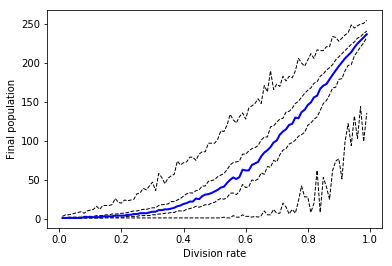

In [12]:
# graph
plt.plot(div_rates,pop_fin,'k--',linewidth=1)
plt.plot(div_rates,[a[2] for a in pop_fin],'b',linewidth=2)
plt.xlabel('Division rate')
plt.ylabel('Final population')
plt.savefig('d1_fun.eps' ,  bbox_inches='tight' , format='eps', dpi=400)
plt.savefig('d1_fun.png' ,  bbox_inches='tight' , dpi=400)
plt.show()

In [ ]:
# Estimation of d1, based on the relationship and the experimental colony size data of "resistant cell" ("criz_ref_data" and "lorl_ref_data") 
criz_d1, lorl_d1 = [[np.interp(a, [a[2] for a in pop_fin], div_rates) for a in dt]
                                      for dt in [criz_ref_data[-1], lorl_ref_data[-1]]]

$\large{\textbf{Clonogenic assay simulations (crizotinib)}}$

In [19]:
# model parameters
n_gen = i_time
n_snap = 2
div_low_median=0.13 # for crizotinib
div_up=np.random.choice(criz_d1,n_sim) # for crizotinib
n_steps = [300,200,100,30,10,3,1] # 7 different evolution steps

In [ ]:
#KL evaluations over ranges of "mu1" and "n_step"
kl_list = []
file_name = ["1","p3","p1","p03","p01","p003","p001","p0003","p0001","0"]

for ii, mu1 in enumerate([1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.]):
    mu_prob = np.clip([mu1*a for a in n_steps],0,1)
    start = time.time()
    kl_list.append([sim_3wk_clonogenic_essay(
        [mu_prob[jj]], [n_steps[jj]]
        , div_low=div_low_median, div_up=div_up, exp_data=lorl_ref_data[1:4], n_sim=100000
        , saving=True, savename="pop"+file_name[ii]+"and"+str(n_steps[jj]))[0] 
                    for jj in range(7)])
    end = time.time()
    print(end - start)

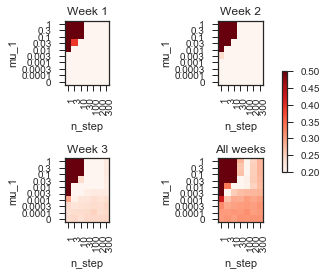

In [190]:
# figure
fig, axes = plt.subplots(2,2)
axes[0,0].imshow([[list[i][0] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Reds')

axes[0,1].imshow([[list[i][1] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Reds')

axes[1,0].imshow([[list[i][2] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Reds')

im = axes[1,1].imshow([[sum(list[i]) for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Reds')

[(a.set_xticks(np.arange(7)),
  a.set_yticks(np.arange(10)),
  a.set_xticklabels(["  1","  3"," 10"," 30"," 100"," 200"," 300"]),
  a.set_yticklabels(["1","0.3","0.1","0.03","0.01","0.003","0.001","0.0003","0.0001","0"]),
  plt.setp(a.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor"), 
  a.set_xlabel("n_step"), 
  a.set_ylabel("mu_1")) for a in [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]]

axes[0,0].set_title("Week 1")
axes[0,1].set_title("Week 2")
axes[1,0].set_title("Week 3")
axes[1,1].set_title("All weeks")

fig.tight_layout()

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

plt.savefig('criz_heatmap.eps' ,  bbox_inches='tight' , format='eps', dpi=400)
plt.show()

$\large{\textbf{Clonogenic assay simulations (loratinib)}}$

In [19]:
# model parameters
n_gen = i_time
n_snap = 2
div_low_median=0.1 # for lorlatinib
div_up=np.random.choice(lorl_d1,n_sim) # for lorlatinib
n_steps = [300,200,100,30,10,3,1] # 7 different evolution steps

In [ ]:
#KL evaluations over ranges of "mu1" and "n_step"
kl_list = []
file_name = ["1","p3","p1","p03","p01","p003","p001","p0003","p0001","0"]

for ii, mu1 in enumerate([1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.]):
    mu_prob = np.clip([mu1*a for a in n_steps],0,1)
    start = time.time()
    kl_list.append([sim_3wk_clonogenic_essay(
        [mu_prob[jj]], [n_steps[jj]] 
        , div_low=div_low_median, div_up=div_up, exp_data=lorl_ref_data[1:4], n_sim=100000
        , saving=True, savename="pop"+file_name[ii]+"and"+str(n_steps[jj])+"_lorl")[0] 
                    for jj in range(7)])
    end = time.time()
    print(end - start)

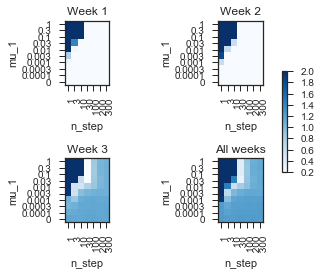

In [189]:
# figure
fig, axes = plt.subplots(2,2)
axes[0,0].imshow([[list[i][0] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Blues')

axes[0,1].imshow([[list[i][1] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Blues')

axes[1,0].imshow([[list[i][2] for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Blues')

im = axes[1,1].imshow([[sum(list[i]) for i in range(len(mu_prob)-1,-1,-1)] 
                        for list in kl_list]
                       , vmin=0.2, vmax=0.5, cmap='Blues')

[(a.set_xticks(np.arange(7)),
  a.set_yticks(np.arange(10)),
  a.set_xticklabels(["  1","  3"," 10"," 30"," 100"," 200"," 300"]),
  a.set_yticklabels(["1","0.3","0.1","0.03","0.01","0.003","0.001","0.0003","0.0001","0"]),
  plt.setp(a.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor"), 
  a.set_xlabel("n_step"), 
  a.set_ylabel("mu_1")) for a in [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]]

axes[0,0].set_title("Week 1")
axes[0,1].set_title("Week 2")
axes[1,0].set_title("Week 3")
axes[1,1].set_title("All weeks")

fig.tight_layout()

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

plt.savefig('lorl_heatmap.eps' ,  bbox_inches='tight' , format='eps', dpi=400)
plt.show()

$\large{\textbf{Time history plots}}$

In [61]:
n_stitch=5
grid_size=10

In [62]:
def visualize_snapshots(microenv_list#, cell_counts
                        ,  savefig=False, savename='savename'):

    if len(microenv_list)>0:

        fig1 = plt.figure()
        gs = gridspec.GridSpec( int(np.ceil(len(microenv_list)/4 ) ) , 4, hspace=0.2 )

        cdict1 = {'red':   ((0.0, 0.5, 0.5),
                           (1.0, 0.0, 0.0)),
                 'green': ((0.0, 0.5, 0.5),
                          (1.0, 0.0, 0.0)),
                 'blue':  ((0.0, 0.5, 0.5),
                          (1.0, 1.0, 1.0))
        }
        blue_gray = colors.LinearSegmentedColormap('BlueGray1', cdict1)
        
        for fignum in range( len(microenv_list) ):

            gen, grid, div_grid = microenv_list[fignum][:3]
            ax = fig1.add_subplot( gs[fignum] )
            ax.set_aspect('equal')

            matrix = np.matrix(grid)
                       
            plt.imshow(matrix, interpolation='nearest', cmap=blue_gray, vmin=0, vmax=1)

            ax.set_axis_off()
            if gen==9:
                ax.set_title( 't='+str(gen)+' (1 week)' )
            else:
                ax.set_title( 't='+str(gen) )

        if savefig:
            fig1.savefig(savename+'.eps' ,  bbox_inches='tight' , dpi=400)

In [63]:
microenv_lists = []
for i in range(i_hor*i_ver):
    microenv_lists.append(run_automaton( grid_size=grid_size , n_gen=9 , n_snap=4
                                        , mu_rate=0.1, div_range=[0.13, 0.35]
                                        , n_step=10 
                                        , ini_div = 0.13, ini_step = 0))

In [64]:
microenv_graph = []
for ii in range(len(microenv_lists[0])):
    grid_comb = np.array([[0 for i in range(n_stitch*grid_size)] for i in range(n_stitch*grid_size)])
    div_grid_comb = np.array([[0 for i in range(n_stitch*grid_size)] for i in range(n_stitch*grid_size)])
    for jj in range(n_stitch):
        for kk in range(n_stitch):
            j = grid_size*jj
            k = grid_size*kk
            grid_comb[j : j+grid_size , k : k+grid_size] = microenv_lists[n_stitch*jj+kk][ii][1]
            div_grid_comb[j : j+grid_size , k : k+grid_size] = microenv_lists[n_stitch*jj+kk][ii][2]
    microenv_graph.append([microenv_lists[0][ii][0], grid_comb, div_grid_comb])

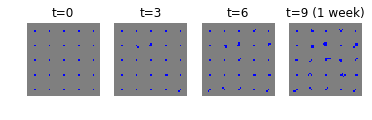

In [65]:
visualize_snapshots(microenv_graph, savefig=True, savename='tumor_pop')
plt.show()

$\large{\textbf{Clonogenic assay with different drug explsure durations}}$

In [4]:
def sim_3wk_clonogenic_assay_oneex(grid_size, mu_rate, n_step, div_low, div_up):
    n_gen = 3*9
    n_snap = 4
    
    microenv_list = run_automaton(grid_size=grid_size , n_gen=n_gen , n_snap=4
                                  , mu_rate=mu_rate, div_range=[div_low, div_up]
                                  , n_step=n_step 
                                  , ini_div = div_low, ini_step = 0)
    result_list = []
    for k in range(1,n_snap):
        grid, div_rate, step = microenv_list[k][1:]
        ind_old = np.where(grid!=0)
        rand_ind = np.random.choice(len(ind_old[0]))
        ind = ind_old[0][rand_ind], ind_old[1][rand_ind]
        result_list.append(run_automaton(grid_size=grid_size , n_gen=9 , n_snap=2
                                         , mu_rate=mu_rate, div_range=[div_low, div_up]
                                         , n_step=n_step 
                                         , ini_div=div_rate[ind], ini_step=step[ind])[1][1:])
    return result_list

In [5]:
def visualize_snapshots(cloessay_list
                        , savefig=False, savename='savename'):

    if len(cloessay_list)>0:

        fig1 = plt.figure()
        gs = gridspec.GridSpec( int(np.ceil(len(cloessay_list)/4 ) ) , 4, hspace=0.2 )

        cdict1 = {'red':  ((0.0, 0.5, 0.5),
                           (1.0, 0.0, 0.0)),
                 'green': ((0.0, 0.5, 0.5),
                           (1.0, 0.0, 0.0)),
                 'blue':  ((0.0, 0.5, 0.5),
                           (1.0, 1.0, 1.0))}
        
        green_gray = colors.LinearSegmentedColormap('GreenGray1', cdict1)
        
        for fignum in range( len(cloessay_list) ):
            grid, div_grid = cloessay_list[fignum][:2]
            ax = fig1.add_subplot( gs[fignum] )
            ax.set_aspect('equal')

            matrix = np.matrix(grid)
#            matrix = np.matrix(div_grid)
                       
            plt.imshow(matrix, interpolation='nearest', cmap=green_gray, vmin=0, vmax=1)

            ax.set_axis_off()
            ax.set_title( str(fignum+1)+'-week' )
            
        if savefig:
            fig1.savefig(savename+'.eps' ,  bbox_inches='tight' , dpi=400)

In [6]:
i_hor=5
i_ver=5
grid_size=10

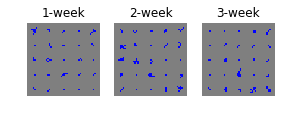

In [35]:
mu_rate=0.1
n_step=30
div_low=0.13
div_up=0.35

cloassay_lists = []
for i in range(i_hor*i_ver):
    cloassay_lists.append(sim_3wk_clonogenic_assay_oneex(grid_size=grid_size, mu_rate=mu_rate, n_step=n_step, div_low=div_low, div_up=div_up))
    
cloassay_graph = []
for ii in range(len(cloassay_lists[0])):
    grid_comb = np.array([[0 for i in range(i_hor*grid_size)] for i in range(i_ver*grid_size)])
    div_grid_comb = np.array([[0 for i in range(i_hor*grid_size)] for i in range(i_ver*grid_size)])
    for jj in range(i_ver):
        j = grid_size*jj
        for kk in range(i_hor):
            k = grid_size*kk
            grid_comb[j : j+grid_size , k : k+grid_size] = cloassay_lists[i_ver*jj + kk][ii][0]
            div_grid_comb[j : j+grid_size , k : k+grid_size] = cloassay_lists[i_ver*jj + kk][ii][1]
    cloassay_graph.append([grid_comb, div_grid_comb])
    
visualize_snapshots(cloassay_graph, savefig=True, savename='cloneessay2D_30step')
plt.show()